In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict,Optional

from agents.youtube_post_agent import generate_youtube_content
from agents.topic_learning_agent import learning_agent
from agents.article_post_agent import article_post_content
from agents.router_agent import router_agent

ModuleNotFoundError: No module named 'agents'

In [27]:
class AgentState(TypedDict):
    query:str
    next_node:Optional[str]
    response:Optional[str]

In [28]:
graph=StateGraph(AgentState)

In [29]:
def youtube_content_node(state:AgentState)-> AgentState:
    state['response']= generate_youtube_content(state['query'])
    return state

In [30]:
def course_finder_node(state:AgentState)-> AgentState:
    state['response']=learning_agent(state['query'])
    return state

In [31]:
def article_content_node(state:AgentState)->AgentState:
    state['response']=article_post_content(state['query'])
    return state

In [32]:
graph.set_entry_point("Router_Agent")

In [33]:
def router_node(state:AgentState)-> AgentState:
    state['next_node']=router_agent(state['query'])
    
    return state

In [34]:
graph.add_node("Router_Agent",router_node)
graph.add_node("youtube_content",youtube_content_node)
graph.add_node("course_finder",course_finder_node)
graph.add_node("article_content",article_content_node)

In [35]:
graph.add_conditional_edges(
    source="Router_Agent",
    path=lambda state : state['next_node'],
    path_map={
        "topic_learning_agent":"course_finder",
        "youtube_post_agent":"youtube_content",
        "article_post_agent":"article_content"
    }
)

In [36]:
graph.set_finish_point("youtube_content")
graph.set_finish_point("course_finder")
graph.set_finish_point("article_content")

In [37]:
app=graph.compile()

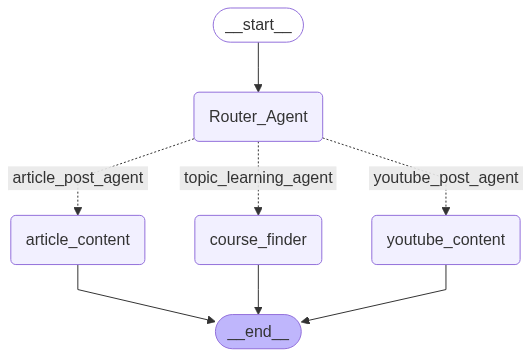

In [38]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [44]:
inputs={"query":"create content for https://www.youtube.com/watch?v=BGTx91t8q50"}

In [47]:
result=app.invoke(inputs)

2025-05-29 13:18:12.553 | INFO     | agents.router_agent:router_agent:18 - query: create content for https://www.youtube.com/watch?v=BGTx91t8q50
2025-05-29 13:18:12.556 | INFO     | agents.router_agent:router_agent:23 - prompt entered to router text="You are a multi-agent router responsible for selecting the most suitable agent to handle the user's query. Choose one agent from the list below based on the task described.\n\n    Available Agents:\n    - topic_learning_agent: Fetches learning resources such as YouTube videos, playlists, and online courses based on a topic provided by the user.\n    - youtube_post_agent: Generates social media posts (LinkedIn, Twitter, Reddit) based on the content of a provided YouTube video link.\n    - article_post_agent: Generates social media posts (LinkedIn, Twitter, Reddit) based on the content of a provided web article link.\n\n    Routing Logic:\n    1. If the user provides a **topic they want to learn about**, and is asking for **learning resource



> Entering new AgentExecutor chain...


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

In [ ]:
print(result)

In [43]:
print(result["response"])

Here are the top 5 most relevant learning resources for Java, from both YouTube and online courses:

**YouTube Resources:**

1.  **Title:** Java Tutorial for Beginners
    *   **Channel Name:** Telusko
    *   **URL:** https://www.youtube.com/watch?v=BGTx91t8q50
    *   **Duration:** 12:23:23
    *   **Brief Description:** N/A

2.  **Title:** Java Full Course for Beginners
    *   **Channel Name:** Programming with Mosh
    *   **URL:** https://www.youtube.com/watch?v=eIrMbAQSU34
    *   **Duration:** 2:30:48
    *   **Brief Description:** N/A

3.  **Title:** Java Full Stack Developer Roadmap 2025 🔥 | Complete Guide for Beginners to Advanced
    *   **Channel Name:** Ashok IT
    *   **URL:** https://www.youtube.com/watch?v=za6zAcAoiT8
    *   **Duration:** 2:46
    *   **Brief Description:** N/A

4.  **Title:** Java Tutorial for Beginners | Learn Java in 2 Hours
    *   **Channel Name:** Apna College
    *   **URL:** https://www.youtube.com/watch?v=UmnCZ7-9yDY
    *   **Duration:** 2: